# Voter Email Insights
Skylar Durst, Ivan Pachev, Jeremy Kerfs

Cal Poly, CSC 582, Natural Language Processing, Prof. Foaad Khosmood

Corpus: New Hampshire Voter Email Corpus 2016


# Preprocessing

The data was extracted from the mbox files the Python `mailbox` package.  We kept the candidate, the candidates party, and the date and body text of each message sent by the candidate.  The data was saved as JSON files.

When utilizing the text from the emails, we removed all of the punctuation, stopwords, and "useless" words.  These "useless" words are artifacts of the emails and do not reflect the message sent by the candidate.  Examples of "useless" words include "http" and "www", which are obviously just part of urls.  Additionally, less obvious words like "EMILY" and "eventbrite" were expunged from the data since they correspond to how the candidate maintains their email lists and not the content of their messages.


In [1]:
import nltk
import nltk.corpus
from nltk.sentiment import SentimentAnalyzer

from dateutil.parser import parse

import pytz

from itertools import groupby

import matplotlib.pyplot as plt
import mpld3

import numpy as np

from random import randint

from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_curve, roc_curve

import pandas as pd

from prepare_data import retrieve_data

%matplotlib inline

In [2]:
data = retrieve_data()
candidates = data.keys()

# Who talks about Whom?

## Technique
We traversed each message of each candidate and counted the number of times each candidate mentions every other candidate (including themselves).  Since some candidates send many more emails than others, we normalized the mentions by dividing by the number of emails sent by each candidate.

A heatmap was then created to show the relationship between each candidate and the other candidates that they mention.

## Results
The number of times that a candidate referes to themselves is not a very interesting feature; the format of the emails can cause a candidate's own name to appear many times while they are not explicitly talking about themselves.

The more interesting results is what candidates talk about other candidates.  Chris Christie actually mentions Donald Trump more 2.5 times per email that he sent!  Fiorina mentioned 9 out of the 11 other candidates - more than any other candidate.

In [3]:
useless_words = ["donaldjtrump", "eventbrite", "10022This", "98xjsmith", "org",\
                 "unsubscribe", "donaldtrump", "Inc725", "http", "https","nationbuilder", \
                 "gmail", "TrumpTEXT", "EXCLUSIVE", "EMILY's", "emilys", "emilyslist",
                "EMILY", "List", "www", "com", "URL"]
stopwords = set(nltk.corpus.stopwords.words("english") + useless_words)



words = [(candidate, w) for candidate in data
         for m in data[candidate]["messages"]
         for w in nltk.word_tokenize(m["body"]) 
         if w.isalpha() and w not in stopwords]

cfd = nltk.ConditionalFreqDist(words)

Count                                                    \
Mentioned      Bush    Carson  Christie   Clinton      Cruz   Fiorina   
Mentioner                                                               
Bush       0.103448  0.034483  0.103448  0.103448  0.086207  0.034483   
Carson     0.000000  4.833333  0.000000  0.000000  0.000000  0.000000   
Christie   0.000000  0.000000  2.225352  0.281690  0.000000  0.000000   
Clinton    0.000000  0.007407  0.007407  0.188889  0.037037  0.000000   
Cruz       0.016667  0.016667  0.000000  0.183333  6.591667  0.050000   
Fiorina    0.053571  0.017857  0.053571  0.392857  0.714286  0.232143   
Kasich     0.029412  0.000000  0.029412  0.666667  0.558824  0.009804   
Paul       0.000000  0.000000  0.000000  0.090909  0.000000  0.000000   
Rubio      0.000000  0.000000  0.008130  0.252033  0.040650  0.000000   
Sanders    0.010490  0.000000  0.000000  0.846154  0.003497  0.000000   
Santorum   0.000000  0.000000  0.000000  0.258065  0.032258  0.000000   
Trump      0.000000  0.000000  0.000000  0.317757  0.000000  0.000000   

                                                                       
Mentioned    Kasich      Paul     Rubio   Sanders  Santorum     Trump  
Mentioner                                                              
Bush       0.137931  0.000000  0.172414  0.000000  0.000000  0.068966  
Carson     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
Christie   0.000000  0.014085  0.028169  0.000000  0.000000  2.549296  
Clinton    0.029630  0.003704  0.007407  0.044444  0.000000  0.551852  
Cruz       0.066667  0.058333  0.158333  0.000000  0.008333  1.400000  
Fiorina    0.071429  0.017857  0.035714  0.000000  0.000000  0.392857  
Kasich     4.235294  0.019608  0.029412  0.019608  0.000000  0.666667  
Paul       0.000000  2.454545  0.000000  0.000000  0.000000  0.000000  
Rubio      0.000000  0.000000  1.975610  0.024390  0.000000  0.024390  
Sanders    0.003497  0.069930  0.000000  0.807692  0.000000  0.258741  
Santorum   0.000000  0.000000  1.032258  0.032258  1.129032  0.193548  
Trump      0.000000  0.018692  0.000000  0.000000  0.000000  4.046729

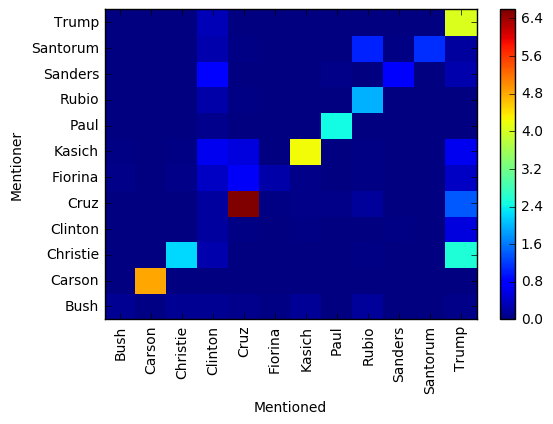

In [4]:
candidate_mentions = [(k, o, cfd[k][o] / float(len(data[k]["messages"]))) for k in cfd.keys() for o in candidates]

mentioner, mentioned, counts = list(zip(*candidate_mentions))
indices = pd.MultiIndex.from_tuples(list(zip(mentioner, mentioned)),names=['Mentioner', 'Mentioned'])
mention_matrix = pd.DataFrame({"Count": counts}, index=indices).unstack()
plt.pcolor(mention_matrix)
plt.yticks(np.arange(0.5, len(mention_matrix.index), 1), mention_matrix.index)
plt.xticks(np.arange(0.5, len(mention_matrix.columns), 1), mention_matrix.index,rotation=90)
plt.xlabel("Mentioned")
plt.ylabel("Mentioner")

plt.colorbar()
mention_matrix

# TF-IDF Singular Value Decomposition

## Technique
Many NLP features are large sparse vectors that are difficult to interpret and understand.  TF-IDF features are important for grouping and comparing documents; we used the TF-IDF features for each candidates entire corpus of text to uncover similarities between the words used by each candidate.

We visualized the relationships using Singular Value Decomposition, which creates a projection of the high-dimensional TF-IDF features into a two-dimensional plane.  By reducing the number of features to only two, we can then plot the candidates on a graph to see who use the most similar language.  Singular Value Decomposition outputs vectors that best explain the variations in the candidate's TF-IDF features.

## Results
Clinton and Sanders - the only two Democrats - appear closely related in the bottom-center of the SVD projection.  Of the Republicans, Bush and Fiorina appear to have TF-IDF features that are most closely related to the language used by the Democrats.  The bar chart below shows what terms were the most important in the features.  Not surprisingly, Trump has the highest value in the 1st component (x-direction) since the second highest weight of this feature is the word "trump".  Paul and Cruz have the highest score in the 2nd component, since the second component weights the terms "paul" and "cruz" very high.

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stopwords)
txts = [" ".join(map(lambda x: " ".join(nltk.word_tokenize(x["body"])), data[k]["messages"])) for k in candidates]
mat = tfidf.fit_transform(txts)

svd = TruncatedSVD(n_components=2, n_iter=12, random_state=42)
svd.fit(mat)
transformed = svd.fit_transform(mat)
fig = plt.figure(figsize=(12,8))

colors = ["red" if data[k]["party"] == "Republicans" else "blue" for k in candidates]
width = max(transformed[:,0])
height = max(transformed[:,1])
scatter = plt.scatter(transformed[:,0]/width, transformed[:,1]/height, label=candidates, c=colors, s=60)
plt.title("Candidates", size=20)
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=list(candidates))
mpld3.plugins.connect(fig, tooltip)

mpld3.display()


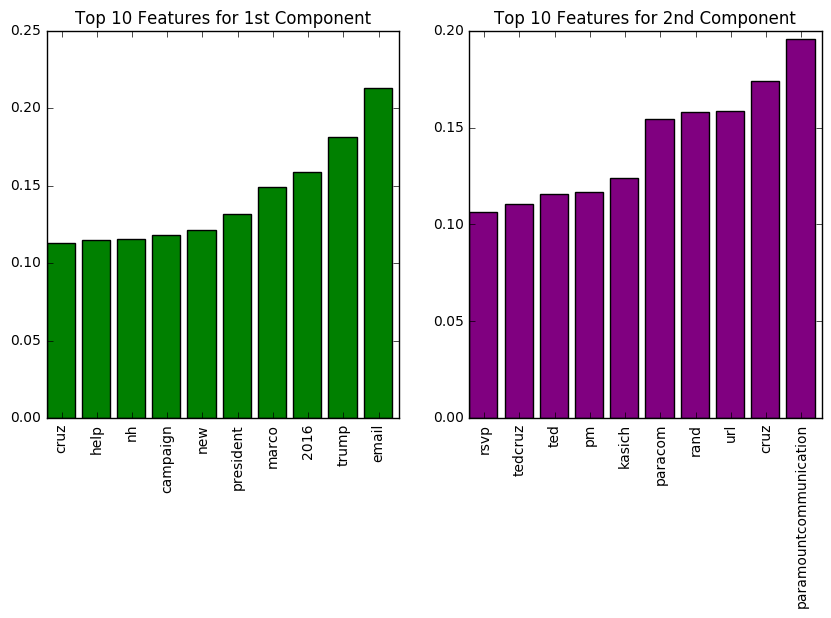

In [6]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
labels = []
vals = []
for i in np.argsort(svd.components_[0])[-10:]:
    labels.append(tfidf.get_feature_names()[i])
    vals.append(svd.components_[0][i])
plt.bar(range(10), vals, color="green")
plt.xticks(np.arange(10)+.425, labels, rotation=90)
plt.title("Top 10 Features for 1st Component")

plt.subplot(1,2,2)
labels = []
vals = []
for i in np.argsort(svd.components_[1])[-10:]:
    labels.append(tfidf.get_feature_names()[i])
    vals.append(svd.components_[1][i])
plt.bar(range(10), vals, color="purple")
plt.xticks(np.arange(10)+.425, labels, rotation=90)
plt.title("Top 10 Features for 2nd Component")
plt.show()

# Predicting When an Email Was Sent

## Technique
Politicians often change their tone and message after the primaries to appeal to the general public or shift their support if they lost.  In this section, we attempted to predict whether an email was sent before or after Trump achieved sufficient votes to win the Republican Primary.  We used TF-IDF features and simple Logistic Regression to predict when each email was sent.

## Results
About 30% of emails were sent after Trump clinched the Republican nomination.  We achieve about 85 to 90% accuracy on a held-out test set when predicting whether an email was sent before or after Trump wins the Republican nomination.  The most interesting result of this experiment was which features were the most informative.  You can see that the presence of "Trump" makes an email more likely to be after Trump wins the Republican nomination while words like "Cruz", "February", and "Ted" make it less likely for an email to be written after Trump wins the Republican nomination.

Accuracy: 0.8629441624365483


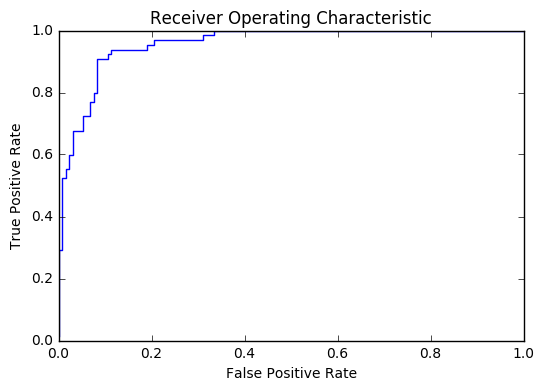

In [7]:
prec_recall = []
roc = []
trump_wins_primary = (np.datetime64("2016-05-26") - np.datetime64('2016-01-01')) / np.timedelta64(1, 'D')
vec = DictVectorizer()
bows = []
labels = []
for c in candidates:
    for m in data[c]["messages"]:
        days = (np.datetime64(parse(m["date"][5:16])) - np.datetime64('2016-01-01')) / np.timedelta64(1, 'D')
        bows.append(" ".join([w for w in nltk.word_tokenize(m["body"]) if w not in stopwords if w.isalpha()]))
        labels.append(days)
tfidf = TfidfVectorizer(stop_words=stopwords)
feats = tfidf.fit_transform(bows)

labels = [l > trump_wins_primary for l in labels]
yTrain, yTest, xTrain, xTest = train_test_split(labels, feats, test_size=0.15)
lm = LogisticRegression()
lm.fit(xTrain, yTrain)
from sklearn.model_selection import cross_val_score
print("Accuracy: {}".format(lm.score(xTest,yTest)))
from sklearn.metrics import roc_curve
fpr, tpr, thresh = roc_curve(yTest, lm.predict_proba(xTest)[:,1])
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.show()

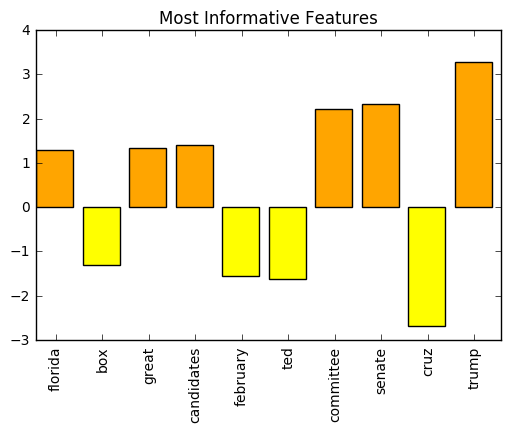

In [8]:
num_feats = 10
abscoefs = abs(lm.coef_)
bst_indices = np.argsort(abscoefs).flatten()[-num_feats:]
weights = [lm.coef_.flatten()[i] for i in bst_indices]
effect = list(map(lambda x: "orange" if x > 0 else "yellow", weights))
plt.bar(range(num_feats), weights, color=effect)
plt.xticks(np.arange(num_feats) + .425, [tfidf.get_feature_names()[i] for i in bst_indices], rotation=90)
plt.title("Most Informative Features")
plt.show()

# Most Popular Words

## Technique
We created WordClouds using the `wordcloud` library for Python.  Basically, the wordclouds show the most common words used by the candidates.  The larger the word, the more commonly the word is used.

## Results
The wordclouds above show that there is not too much diversity between the candidates' word choice, other than Hillary talking about women and Trump talking about corporations. Based solely on the Hillary wordcloud, it seems that Hillary is determined to convince people that her email server was "secure" and that she was "authorized" to use it. It also looks like Trump talked about Hillary more than Hillary talked about Trump.

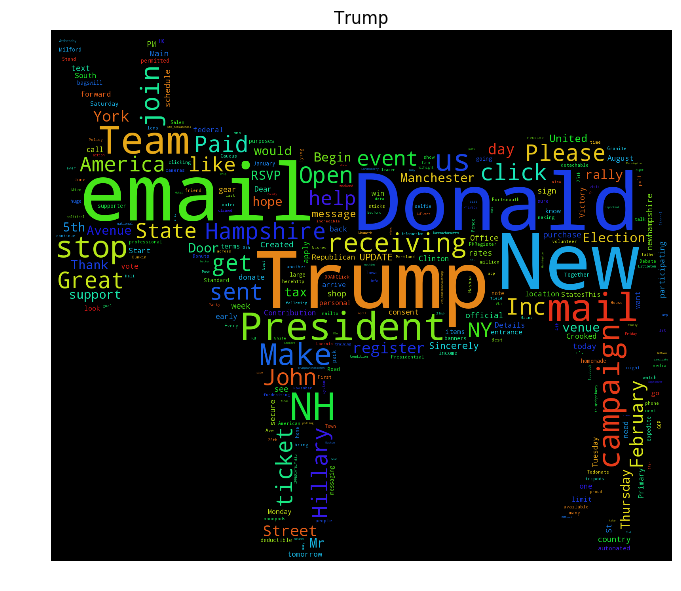

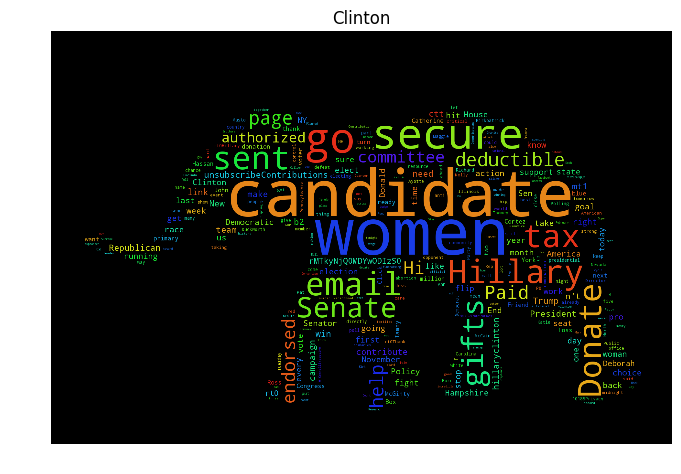

In [9]:
from PIL import Image
from os import path
import random
from wordcloud import WordCloud

def show_wordCloud(img, candidate):
    mask = np.array(Image.open(img))

    text = " ".join([w for message in data[candidate]["messages"] \
                     for w in nltk.word_tokenize(message["body"]) if w not in stopwords])

    wc = WordCloud(max_words=300, mask=mask, stopwords=stopwords, margin=10,random_state=1).generate(text)
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title(candidate)
    plt.imshow(wc.to_array())
    plt.show()

show_wordCloud("wordcloud/donkey.jpg", "Trump")
show_wordCloud("wordcloud/elephant.jpg", "Clinton")